In [371]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
import sklearn

In [372]:
### Question 1 ###

In [373]:
# Bullet point 1
def read_im(file):
    return plt.imread(file)

In [374]:
# Bullet point 2
def show_im(data):
    plt.imshow(data)

In [375]:
# Bullet point 3
def get_patch(i, j, h, im):
    i, j, h = int(i), int(j), int(h/2)
    return im[i-h:i+h, j-h:j+h, :]

In [376]:
# Bullet point 4
def patch_to_vect(patch):
    length = np.prod(patch.shape)
    return np.reshape(patch, length)

def vect_to_patch(h, vector):
    h = int(h)
    if 3 * h * h != vector.size: return None
    return np.reshape(vector, (h, h, 3))

In [377]:
# Bullet point 5
def noise(img, prc):
    if prc == 0.0: return img
    shape = img.shape
    px_number = int(img.size/3 * prc)
    to_del = np.random.randint(0, img.size/3, px_number)
    to_del = np.array([np.array([int(x/shape[1]), x%shape[1]]) for x in to_del]).T
    res = img.copy()
    res[to_del[0], to_del[1],:] = np.array([-100,-100,-100])
    return res

def delete_rect(img, i, j, height, width):
    i, j, h, w = int(i), int(j), int(height/2), int(width/2)
    res = img.copy()
    res[i-h:i+h, j-w:j+w, :] = np.array([-100,-100,-100])
    return res

In [378]:
# Bullet point 6
def get_all_patches(img, step, h):
    shape = img.shape
    first_h, last_h = int(h/2), shape[0] - int(h/2)
    first_w, last_w = int(h/2), shape[1] - int(h/2)
    index_h = sorted(list(range(first_h, int(shape[0]/2), 2*step)) + list(range(last_h, int(shape[0]/2), -2*step)))
    index_w = sorted(list(range(first_w, int(shape[1]/2), 2*step)) + list(range(last_w, int(shape[1]/2), -2*step)))
    res = []
    for i in index_h:
        for j in index_w:
            res.append(get_patch(i, j, h, img))
    return np.array(res)

In [379]:
# Bullet point 6
def get_bad_patches(all_patches):
    res = []
    for patch in all_patches:
        if -100 in np.reshape(patch, patch.size): res.append(patch)
    return np.array(res)

In [380]:
# Bullet point 6
def get_dictionnary(all_patches):
    res = []
    for patch in all_patches:
        if not -100 in np.reshape(patch, patch.size): res.append(patch)
    return np.array(res)

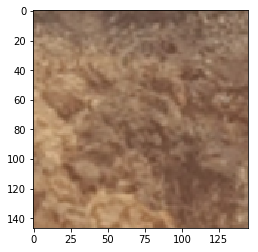

In [381]:
# Load image
desert="../resources/desert.png"
image = read_im(desert)
show_im(image)

In [382]:
# Create a patch, transform and de-transform it into vector
patch = get_patch(100, 100, 10, image)
vector = patch_to_vect(patch)
repatch = vect_to_patch(10, vector)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


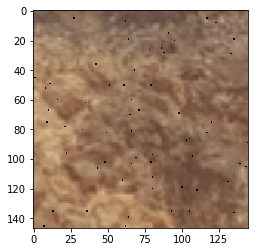

In [384]:
# Put noise on the image
flou = noise(image, 0.003)
rect = delete_rect(image,100,100,10,20)
show_im(flou)

(196, 10, 10, 3)


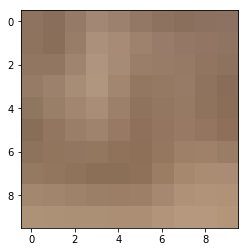

In [385]:
# Get all patches
all_patches = get_all_patches(flou, h=10, step=5)
print(all_patches.shape)
show_im(all_patches[14])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(50, 10, 10, 3)


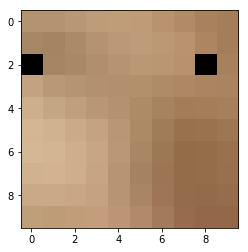

In [386]:
# Get patches with noise
bad_patches = get_bad_patches(all_patches)
print(bad_patches.shape)
show_im(bad_patches[15])

(146, 10, 10, 3)


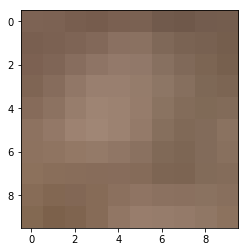

In [387]:
# Get patches without noise
dico = get_dictionnary(all_patches)
print(dico.shape)
show_im(dico[15])

In [388]:
### Question 2 ###

In [389]:
# Removes indexes where pixels are black in patch and in dictionnary + transforms to vectors
def transform_for_lasso(patch_to_pred, dico):
    print(patch_to_pred.shape, dico.shape)
    patch = patch_to_vect(patch_to_pred)
    index = np.argwhere(np.equal(patch, -100))
    patch = np.delete(patch, index)
    patch = np.reshape(patch, (1, patch.size))
    dico = np.array([np.delete(patch_to_vect(p), index) for p in dico])
    # dico = np.reshape(dico, (1, dico.shape[0], dico.shape[1])) si on pouvait faire avec une matrice multidimmensionnelle
    # Contournement du problème :
    dico = np.reshape(dico, (1, dico.shape[0] * dico.shape[1]))
    print(patch.shape, dico.shape)
    return patch, dico

In [390]:
# Essai d'apprentissage avec un batch flouté quelconque
patch_to_pred = get_bad_patches(all_patches)[15]
patch, dico_learn = transform_for_lasso(patch_to_pred, dico)
# Construct and train lasso
reg_lasso = linear_model.Lasso(alpha = 1.0)
reg_lasso.fit(X=dico_learn, y=patch)

(10, 10, 3) (146, 10, 10, 3)
(1, 294) (1, 42924)


Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [391]:
# Get weights, transform them go good shape
w = reg_lasso.coef_
s = w.shape
print(np.sum(w)) # ne devrait pas être 0.0 !!!
# Uniquement avec un w obtenu sur la matrice transformée :
w = np.mean(w, axis=0)
w = np.array([np.mean(w[i:i+s[0]]) for i in range(0, s[1], s[0])])
print(w.shape)

0.0
(146,)


In [392]:
# Recompose patch given patch with noise, weights and dictionnary
def recompose(patch_to_pred, w, dico):
    patch = patch_to_vect(patch_to_pred)
    shape = patch_to_pred.shape
    index = np.argwhere(np.equal(patch, -100))
    dico = np.array([patch_to_vect(p) for p in dico])
    patch[index] = np.dot(w, dico)[index]
    return vect_to_patch(shape[0], patch)

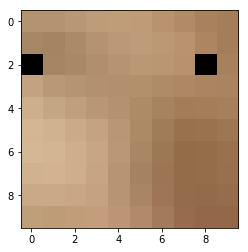

In [393]:
# Compute and show recomposed patch
new_patch = recompose(patch_to_pred, w, dico)
show_im(new_patch)